In [1]:
import time
import multiprocessing
import psutil
import tensorflow as tf
from common import dataloaders
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = "retina"

worker_threads = multiprocessing.cpu_count()

IMG_SIZE = 224
BATCH_SIZE = 256
ITERATIONS = 100

## Naive Example

In [2]:
dataset = dataloaders.return_naive_tfds(dataset_name="imagenet2012",
                                        buffer=16384)
num_class = dataset["num_class"]

@tf.function
def read_example(_image, label):
    image = tf.image.resize_with_pad(_image, IMG_SIZE, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, num_class)
    return image, label

train = dataset["train"]
train = train.map(read_example, num_parallel_calls=worker_threads)
train = train.batch(BATCH_SIZE, drop_remainder=True)
train = train.prefetch(50)
train_iter = iter(train)

print("Running pipeline:")
batch = next(train_iter)
image, label = batch[0].numpy(), batch[1].numpy()
print("* Image shape:", image.shape)
print("* Label shape:", label.shape)

print("Wait for built prefetch cache")
while psutil.cpu_percent(interval=1.0) > 1/worker_threads*100:
    time.sleep(1)
print("CPU:", psutil.cpu_percent(interval=None))
print("Done!")

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imagenet2012 (/home/jovyan/tensorflow_datasets/imagenet2012/5.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/jovyan/tensorflow_datasets/imagenet2012/5.0.0


Found 1000 classes in imagenet2012
Found training examples: 1281167
Found validation examples: 50000
Train output: <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
Valid output: <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
Took 14 seconds to return dataset
Running pipeline:
* Image shape: (256, 224, 224, 3)
* Label shape: (256, 1000)
Wait for built prefetch cache
CPU: 0.0
Done!


Measure overhead: 0.06259655952453613 s
Total time taken: 5.481230020523071
   Images/second: 4670


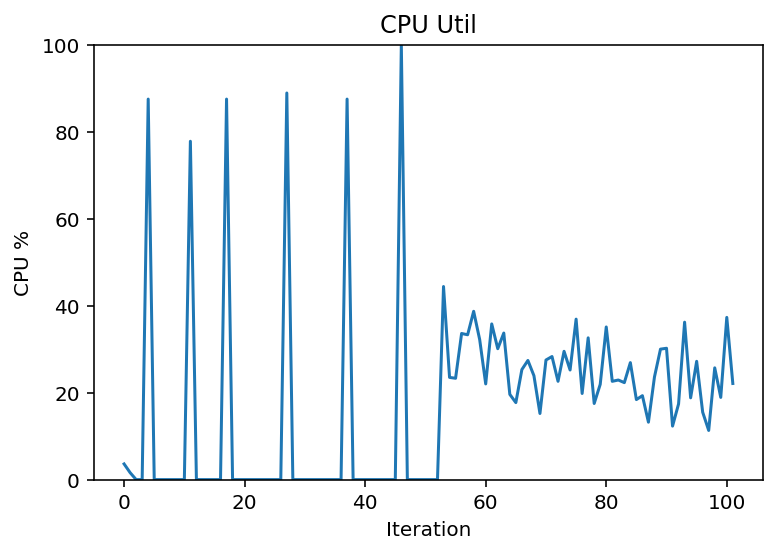

In [3]:
cpu_util = []

print("Measure overhead: ", end="")

st = time.time()
for i in range(1):
    batch = next(train_iter)
    image, label = batch[0], batch[1]
    cpu_util.append(psutil.cpu_percent(interval=None))
image, label = str(batch[0].numpy()), str(batch[1].numpy())
et = time.time()
overhead = et-st

print(overhead, "s")

time.sleep(2)

st = time.time()
for i in range(ITERATIONS+1):
    batch = next(train_iter)
    image, label = batch[0], batch[1]
    cpu_util.append(psutil.cpu_percent(interval=None))
image, label = str(batch[0].numpy()), str(batch[1].numpy())
et = time.time()

duration = et-st-overhead
fps = int(BATCH_SIZE*ITERATIONS/duration)
iter_duration = duration/ITERATIONS
print("Total time taken:", duration)
print("   Images/second:", fps)

x = list(range(len(cpu_util)))
plt.title("CPU Util")
plt.plot(x, cpu_util)
plt.xlabel("Iteration")
plt.ylabel("CPU %")
plt.ylim((0,100))
plt.show()

In [4]:
# clean-up
del dataset, train, read_example
time.sleep(1)
tf.keras.backend.clear_session()

## Fast Example

In [5]:
dataset = dataloaders.return_fast_tfds(dataset_name="imagenet2012",
                                       worker_threads=worker_threads,
                                       buffer=16384)
num_class = dataset["num_class"]

@tf.function
def read_example(_image, label):
    image = tf.io.decode_jpeg(_image, channels=3,
                              fancy_upscaling=False,
                              dct_method="INTEGER_FAST")
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, num_class)
    return image, label

train = dataset["train"]
train = train.map(read_example, num_parallel_calls=worker_threads)
train = train.batch(BATCH_SIZE, drop_remainder=True)
train = train.prefetch(50)
train_iter = iter(train)

print("Running pipeline:")
batch = next(train_iter)
image, label = batch[0].numpy(), batch[1].numpy()
print("* Image shape:", image.shape)
print("* Label shape:", label.shape)

print("Wait for built prefetch cache")
while psutil.cpu_percent(interval=1.0) > 1/worker_threads*100:
    time.sleep(1)
print("CPU:", psutil.cpu_percent(interval=None))
print("Done!")

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imagenet2012 (/home/jovyan/tensorflow_datasets/imagenet2012/5.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/jovyan/tensorflow_datasets/imagenet2012/5.0.0


Found 1000 classes in imagenet2012
Found training examples: 1281167
Found validation examples: 50000
Train output: <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>
Valid output: <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>
Took 0 seconds to return dataset
Running pipeline:
* Image shape: (256, 224, 224, 3)
* Label shape: (256, 1000)
Wait for built prefetch cache
CPU: 0.0
Done!


Measure overhead: 0.06981539726257324 s
Total time taken: 1.8914391994476318
   Images/second: 13534


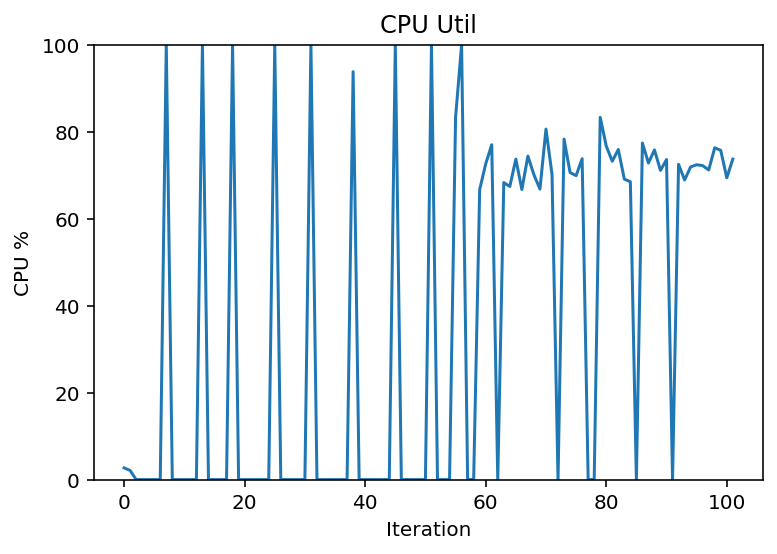

In [6]:
cpu_util = []

print("Measure overhead: ", end="")

st = time.time()
for i in range(1):
    batch = next(train_iter)
    image, label = batch[0], batch[1]
    cpu_util.append(psutil.cpu_percent(interval=None))
image, label = str(batch[0].numpy()), str(batch[1].numpy())
et = time.time()
overhead = et-st

print(overhead, "s")

time.sleep(2)

st = time.time()
for i in range(ITERATIONS+1):
    batch = next(train_iter)
    image, label = batch[0], batch[1]
    cpu_util.append(psutil.cpu_percent(interval=None))
image, label = str(batch[0].numpy()), str(batch[1].numpy())
et = time.time()

duration = et-st-overhead
fps = int(BATCH_SIZE*ITERATIONS/duration)
print("Total time taken:", duration)
print("   Images/second:", fps)

x = list(range(len(cpu_util)))
plt.title("CPU Util")
plt.plot(x, cpu_util)
plt.xlabel("Iteration")
plt.ylabel("CPU %")
plt.ylim((0,100))
plt.show()